# Calculation of DNA-volume via Monte Carlo simulation
<center>
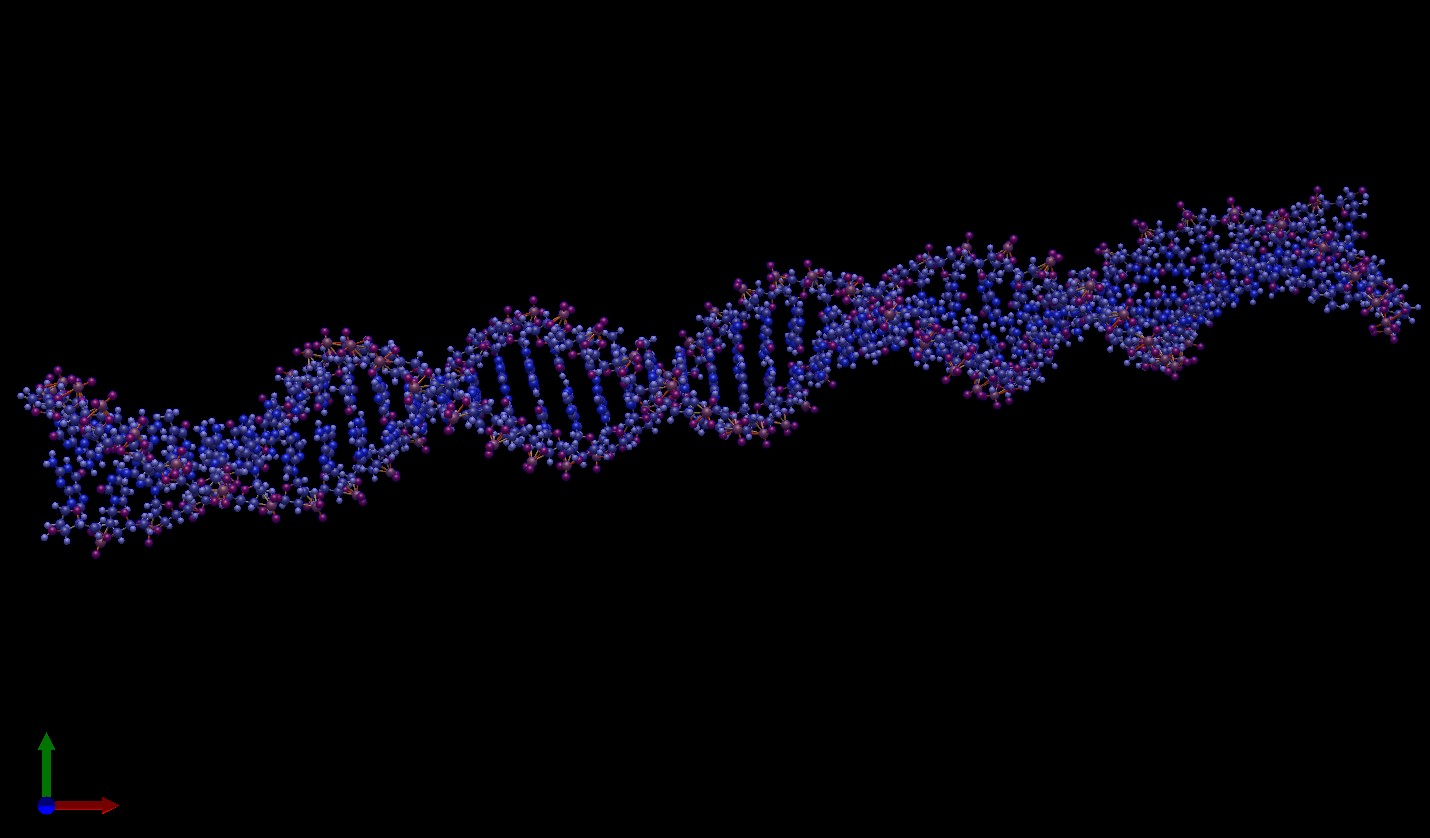
</center>

This notebook explores one approach to calculate the inaccessible molecule volume. The overall approach focuses on Monte Carlo Simulation by generating random points in space and performing multiple random walks to obtain the inaccessible volume of complex structure, in this case a given DNA-molecule.

The basic premise on how to calculate the molecule volume can be mathematically expressed as follows:

<p style="text-align:center; font-size:150%;">
$V_{molecule} = V_{box} - V_{accessible}$
</p>
    
Since the volume of the simulation box is rather easy to obtain, the objective is to find out the accessible volume respectively the complementary volume of the molecule. Doing so analytically for a complex structure like a molecule can be quite cumbersome due to overlapping atomic volumes. This is were numerical approaches like Monte Carlo shine.

The method is quite analogous to the example of calculating pi from a (quarter) circle; in this case, we sample points in 3-dimensional space. Given a large amount of samples, the probability of landing in the accessible volume i.e. not the molecule volume can be approximated from a frequentist view as such:

<p style="text-align:center; font-size:150%;">
$P_{accessible} = \frac{V_{accessible}}{V_{box}} \approx \frac{s_{accepted}}{s_{total}}$ 
</p>

<p style="text-align:center; font-size:150%;">
$V_{accessible} = V_{box} \cdot \frac{S_{accepted}}{S_{total}}$
</p>

If we now substitute into our original premise, we get our notation for calculating the molecule volume:

<p style="text-align:center; font-size:150%;">
$$
V_{molecule} = V_{box} - V_{box} \cdot \frac{S_{accepted}}{S_{total}}
= V_{box} \cdot \left(1 - \frac{S_{accepted}}{S_{total}}\right)
$$
</p>

**Note:** This can be considered the **pure molecule volume**; it does not contain the volume that would be inaccessible for example to a protein trying to dock to the dna-string. 


In [1]:
import time
import sys
import VoCalMol
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(11)
# Define the system variables and constants
trials = 1000
steplength = 3.
elongation = 1.
dpr = 1.82 # atomic radius of dynamic particles, in this case lithium
n_walker = 6
filename = "/home/jonas/PycharmProjects/MolecularModeling/MonteCarloProjectMOD300/Task2_MoleculeVolume/dna_coords.txt"

# read file coordinates and create a dataframe 
dna_df = VoCalMol.read_xyz(filename)

print(f"First few rows of the dna-dataframe:\n{dna_df.head(10)}")

First few rows of the dna-dataframe:
  Element         X         Y        Z  Atomic Mass  Atomic Radius
0       H -98.36758 -10.42177  3.30734       1.0080           1.20
1       O -98.14369 -10.64244  4.20635      15.9990           1.52
2       P -96.71416 -10.28962  4.46438      30.9737           1.80
3       O -96.69328  -8.85662  4.82624      15.9990           1.52
4       O -95.95598 -10.66454  3.24866      15.9990           1.52
5       O -96.20799 -11.16715  5.69692      15.9990           1.52
6       C -97.04481 -11.26336  6.87599      12.0010           1.70
7       C -96.17834 -11.35699  8.11357      12.0010           1.70
8       O -95.72518 -12.74078  8.26146      15.9990           1.52
9       C -94.88947 -10.53822  8.10201      12.0010           1.70


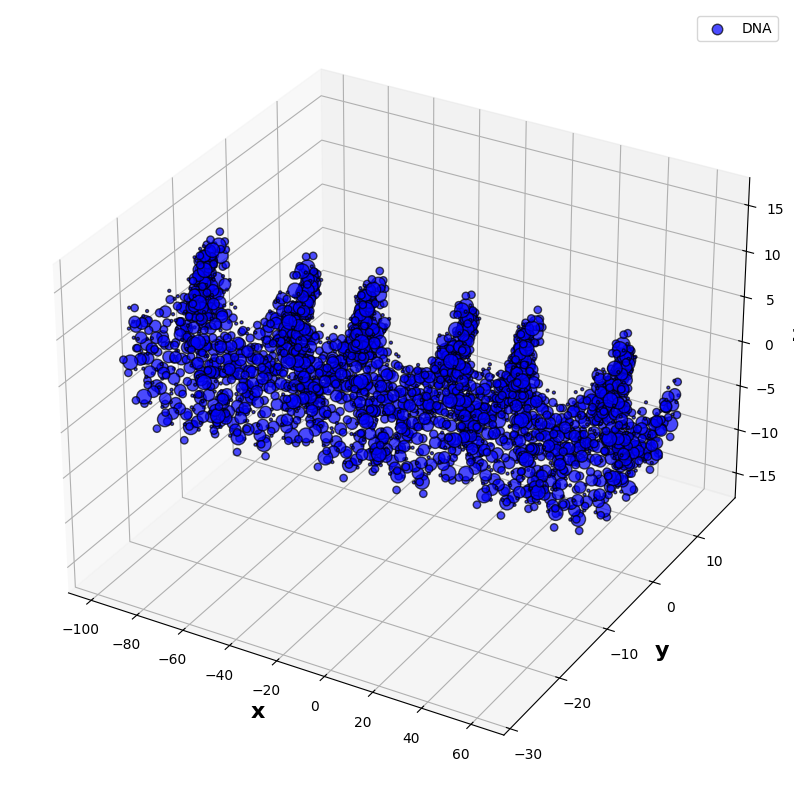

In [2]:
# Generate positional arrays and define simulation box
x, y, z, overlap = VoCalMol.coarse_graining(dataframe=dna_df, grainsize=1)
dna_positions, drop_positions, dim = VoCalMol.init_positions(mode="drop", X=x, Y=y, Z=z, n_trials=trials, 
                                                             addboxlength=elongation)
dna_positions, walk_positions, dim = VoCalMol.init_positions(mode="walk", X=x, Y=y, Z=z, n_trials=trials,
                                                             addboxlength=elongation, n_walker=n_walker)

# vizualize dna-string in 3D
fig = plt.figure(figsize=(10,16))
ax = fig.add_subplot(1,1,1, projection="3d")
ax.scatter(dna_positions[:,0], dna_positions[:,1], dna_positions[:,2], 
           marker="o", color="blue", edgecolor="black",
           s=overlap**8, alpha=0.7, label="DNA")
ax.set_xlabel("x",fontsize=16, fontweight="bold")
ax.set_ylabel("y",fontsize=16, fontweight="bold")
ax.set_zlabel("z",fontsize=16, fontweight="bold")
ax.legend()
#ax.view_init(elev=15, azim=-25)

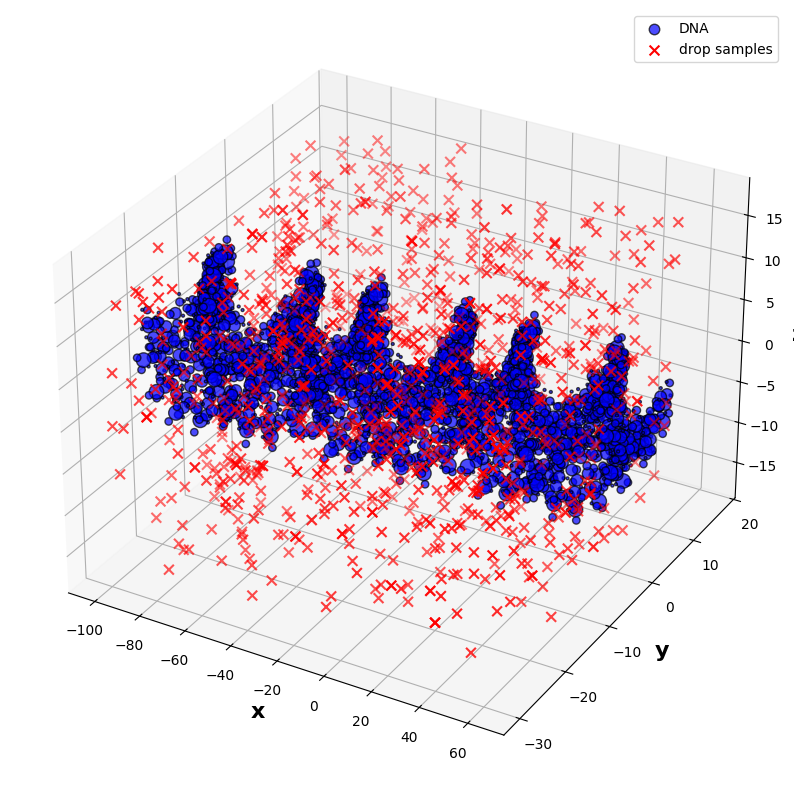

In [3]:
# Run the drop simulation
drop_positions, drop_acceptance = VoCalMol.drop_simulation(static_mol_pos=dna_positions,
                                                           dyn_mol_pos=drop_positions,
                                                           boxdim=dim,
                                                           r_over=overlap)

# vizualize the generated particle drops
fig = plt.figure(figsize=(10,16))
ax = fig.add_subplot(1,1,1, projection="3d")
ax.set_xlabel("x",fontsize=16, fontweight="bold")
ax.set_ylabel("y",fontsize=16, fontweight="bold")
ax.set_zlabel("z",fontsize=16, fontweight="bold")
ax.scatter(dna_positions[:,0], dna_positions[:,1], dna_positions[:,2], 
           marker="o", color="blue", edgecolor="black",
           s=overlap**8, alpha=0.7, label="DNA")
ax.scatter(drop_positions[:,0,:], drop_positions[:,1,:], drop_positions[:,2,:],
           marker="x",color="red", s=50, label="drop samples")
ax.legend()


In [4]:
# Calcuate the pure molecule volume from the accepted drops
V_mol_drop = VoCalMol.calc_molecule_volume(acceptance=drop_acceptance, boxdim=dim)
print(f"Molecule volume excl. inaccessible volume:\n{V_mol_drop:.3f} Å³")

Molecule volume excl. inaccessible volume:
22140.290 Å³


To assert if this output makes somewhat sense, we have to have an estimate. One way of approximating the union volume of the atomic
spheres can be to calculate the cumulative volume of spheres and correct by subtracting the nearest neighbour intersection volume as
the biggest deviation.

In [5]:
# calculate the molecule volume as cumulative atomic volumes, indicating the maximum volume.
atom_volumes = (4/3) * np.pi * overlap**3
reference_volume = atom_volumes.sum()
print(f"Maximum molecule volume:\n{reference_volume:.3f} Å³")

# determine nearest neighbour for each atom - nearest neighbour list
dist = dna_positions[:,np.newaxis,:] - dna_positions[np.newaxis,:,:]
d = np.linalg.norm(dist, axis=2)
d[d==0] = np.inf
nn_list = np.argmin(d,axis=1)

# determine second nearest neighbour

d_sorted = np.sort(d,axis=1)
snn_d = d_sorted[:,1]
tnn_d = d_sorted[:,2]

snn_list = np.zeros_like(nn_list)
tnn_list = np.zeros_like(nn_list)

for i in range(d.shape[0]):
    snn_list[i] = np.where(d[i,:] == snn_d[i])[0][0]
    tnn_list[i] = np.where(d[i,:] == tnn_d[i])[0][0] 

# define function to calculate intercept volume
def v_intercept(d,R,r):
    v_int = (np.pi * ((R+r-d)**2) * (d**2 + 2*d*r - 3*r**2 + 2*d*R + 6*r*R - 3*R**2)) / (12*d)
    return v_int.item()

# calculate intercept volumes
v_ic_nn = []
for i in range(d.shape[0]):
    d_i = d[i,nn_list[i]]
    R_i = overlap[i]
    r_i = overlap[nn_list[i]]
    f = 1

    if d_i >= R_i+r_i: # no interception of spheres
        v_ic_nn.append(0)

    else:

        if i == nn_list[nn_list[i]]: # factoring if two particles are their respective nearest neighbours
            f = .5

        v_i = v_intercept(d=d_i, R=R_i, r=r_i)
        v_ic_nn.append(v_i * f)

v_est_overlap_nn = sum(v_ic_nn)
print(f"\nestimated nearest neighbour overlap volume:\n{v_est_overlap_nn:.3f} Å³")
v_mol_est = reference_volume - v_est_overlap_nn
print(f"\nestimated molecule volume excl. inaccessible volume:\n{v_mol_est:.3f} Å³")

v_ic_snn = []
for i in range(d.shape[0]):
    d_i = d[i,snn_list[i]]
    R_i = overlap[i]
    r_i = overlap[snn_list[i]]
    f = 1

    if d_i >= R_i+r_i: # no interception of spheres
        v_ic_snn.append(0)

    else:

        if i == snn_list[snn_list[i]]: # factoring if two particles are their respective nearest neighbours
            f = .5

        v_i = v_intercept(d=d_i, R=R_i, r=r_i)
        v_ic_snn.append(v_i * f)

v_est_overlap_snn = sum(v_ic_snn)
print(f"\nestimated second nearest neighbour overlap volume:\n{v_est_overlap_snn:.3f} Å³")
v_mol_est = reference_volume - v_est_overlap_nn - v_est_overlap_snn
print(f"\nestimated molecule volume excl. inaccessible volume:\n{v_mol_est:.3f} Å³")

v_ic_tnn = []
for i in range(d.shape[0]):
    d_i = d[i,tnn_list[i]]
    R_i = overlap[i]
    r_i = overlap[tnn_list[i]]
    f = 1

    if d_i >= R_i+r_i: # no interception of spheres
        v_ic_tnn.append(0)

    else:

        if i == tnn_list[tnn_list[i]]: # factoring if two particles are their respective nearest neighbours
            f = .5

        v_i = v_intercept(d=d_i, R=R_i, r=r_i)
        v_ic_tnn.append(v_i * f)

v_est_overlap_tnn = sum(v_ic_tnn)
print(f"\nestimated second nearest neighbour overlap volume:\n{v_est_overlap_tnn:.3f} Å³")
v_mol_est = reference_volume - v_est_overlap_nn - v_est_overlap_snn - v_est_overlap_tnn
print(f"\nestimated molecule volume excl. inaccessible volume:\n{v_mol_est:.3f} Å³")


Maximum molecule volume:
41722.127 Å³

estimated nearest neighbour overlap volume:
11318.983 Å³

estimated molecule volume excl. inaccessible volume:
30403.144 Å³

estimated second nearest neighbour overlap volume:
10158.443 Å³

estimated molecule volume excl. inaccessible volume:
20244.701 Å³

estimated second nearest neighbour overlap volume:
8876.018 Å³

estimated molecule volume excl. inaccessible volume:
11368.683 Å³


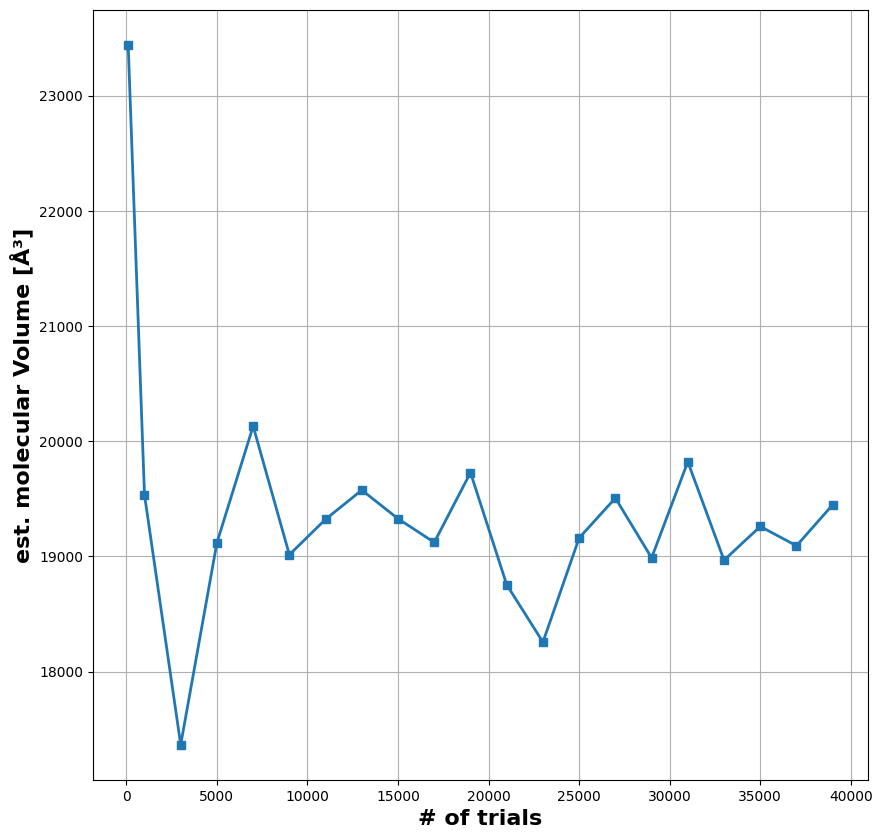

In [25]:
# check the convergence of the value for different numbers of iterations
nt = 100
nt = np.append(nt, 1000 * np.arange(1,40,2))

V_drop_vec = []

for i, trial in enumerate(nt):
    dna_positions, drop_positions, dim = VoCalMol.init_positions(mode="drop", X=x, Y=y, Z=z, n_trials=trial, 
                                                             addboxlength=elongation)
    drop_positions, drop_acceptance = VoCalMol.drop_simulation(static_mol_pos=dna_positions,
                                                               dyn_mol_pos=drop_positions,
                                                               boxdim=dim,
                                                               r_over=overlap)
    V_drop_vec.append(VoCalMol.calc_molecule_volume(acceptance=drop_acceptance, boxdim=dim))
    
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("# of trials",fontsize=16, fontweight="bold")
ax.set_ylabel("est. molecular Volume [Å³]",fontsize=16, fontweight="bold")
ax.plot(nt, V_drop_vec, linewidth = 2, marker="s")
ax.grid(True)

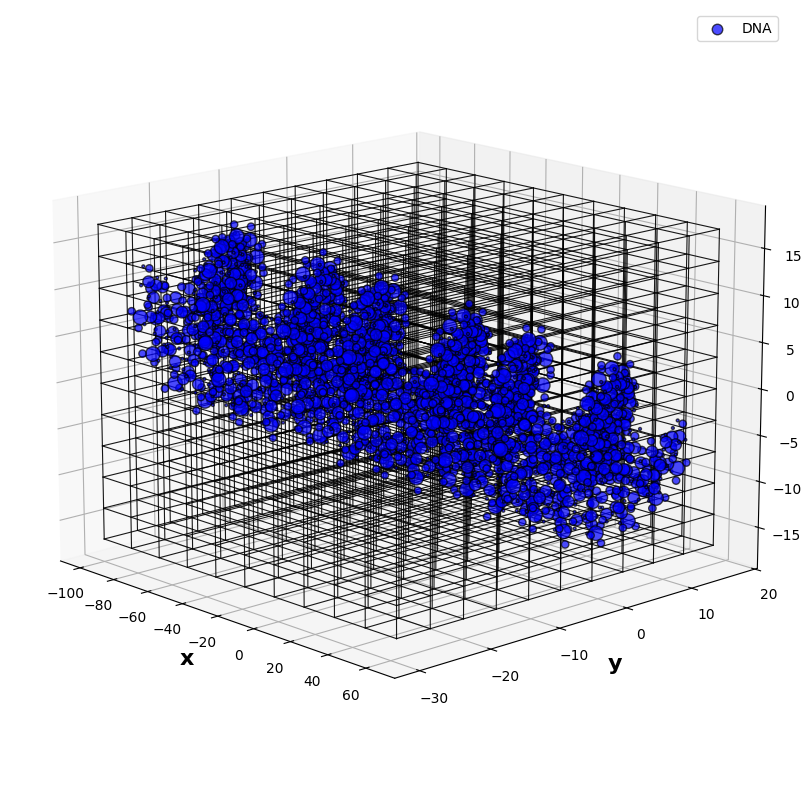

In [7]:
# vizualize discretizaion of simulation box
n_boxes = 10
dx = (dim[0][1] - dim[0][0]) / n_boxes
dy = (dim[1][1] - dim[1][0]) / n_boxes
dz = (dim[2][1] - dim[2][0]) / n_boxes

x_range = np.arange(dim[0][0], dim[0][1] + dx, dx)
y_range = np.arange(dim[1][0], dim[1][1] + dy, dy)
z_range = np.arange(dim[2][0], dim[2][1] + dz, dz)

fig = plt.figure(figsize=(10,16))
ax = fig.add_subplot(1,1,1, projection="3d")
ax.set_xlabel("x",fontsize=16, fontweight="bold")
ax.set_ylabel("y",fontsize=16, fontweight="bold")
ax.set_zlabel("z",fontsize=16, fontweight="bold")
ax.scatter(dna_positions[:,0], dna_positions[:,1], dna_positions[:,2], 
           marker="o", color="blue", edgecolor="black",
           s=overlap**8, alpha=0.7, label="DNA")

for yi in y_range:
    for zi in z_range:
        ax.plot(x_range, [yi]*len(x_range), [zi]*len(x_range), color="black", alpha=0.9, linewidth=0.8)

# Lines parallel to Y-axis
for xi in x_range:
    for zi in z_range:
        ax.plot([xi]*len(y_range), y_range, [zi]*len(y_range), color="black", alpha=0.9, linewidth=0.8)

# Lines parallel to Z-axis
for xi in x_range:
    for yi in y_range:
        ax.plot([xi]*len(z_range), [yi]*len(z_range), z_range, color="black", alpha=0.9, linewidth=0.8)
ax.view_init(elev=15, azim=-43)
ax.legend()

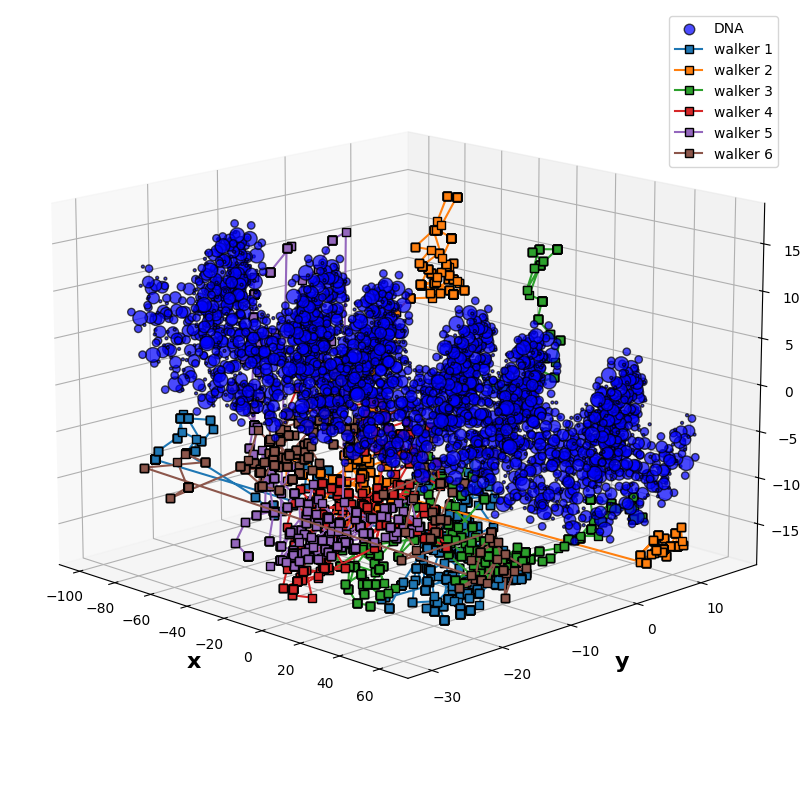

In [8]:
# Run the walk simulation
walk_positions, walk_acceptance = VoCalMol.walk_simulation(static_mol_pos=dna_positions,
                                                           dyn_mol_pos=walk_positions,
                                                           boxdim=dim,
                                                           r_over=overlap,
                                                           stepsize=steplength,
                                                           dyn_particle_radius=dpr)

# vizualize the generated particle drops
fig = plt.figure(figsize=(10,16))
ax = fig.add_subplot(1,1,1, projection="3d")
ax.set_xlabel("x",fontsize=16, fontweight="bold")
ax.set_ylabel("y",fontsize=16, fontweight="bold")
ax.set_zlabel("z",fontsize=16, fontweight="bold")
ax.scatter(dna_positions[:,0], dna_positions[:,1], dna_positions[:,2], 
           marker="o", color="blue", edgecolor="black",
           s=overlap**8, alpha=0.7, label="DNA")
for i in range(walk_positions.shape[0]):
    ax.plot(walk_positions[i,0,:], walk_positions[i,1,:], walk_positions[i,2,:],
            marker="s", markeredgecolor="black", label=f"walker {i+1}", )
ax.legend()
ax.view_init(elev=15, azim=-45)

In [9]:
# Calculate the in accessible volume from both simulation results
V_mol_walk, V_mol_inaccessible = VoCalMol.calc_inaccessible_molecule_volume(dyn_walk_pos=walk_positions,
                                                                            boxdim=dim,
                                                                            V_mol_drop=V_mol_drop,
                                                                            n_boxes=100)

print(f"Molecule volume incl. inaccessible volume:\n{V_mol_walk:.3f} Å³")
print(f"\ninaccessible volume:\n{V_mol_inaccessible:.3f} Å³")

Molecule volume incl. inaccessible volume:
260221.340 Å³

inaccessible volume:
238081.050 Å³


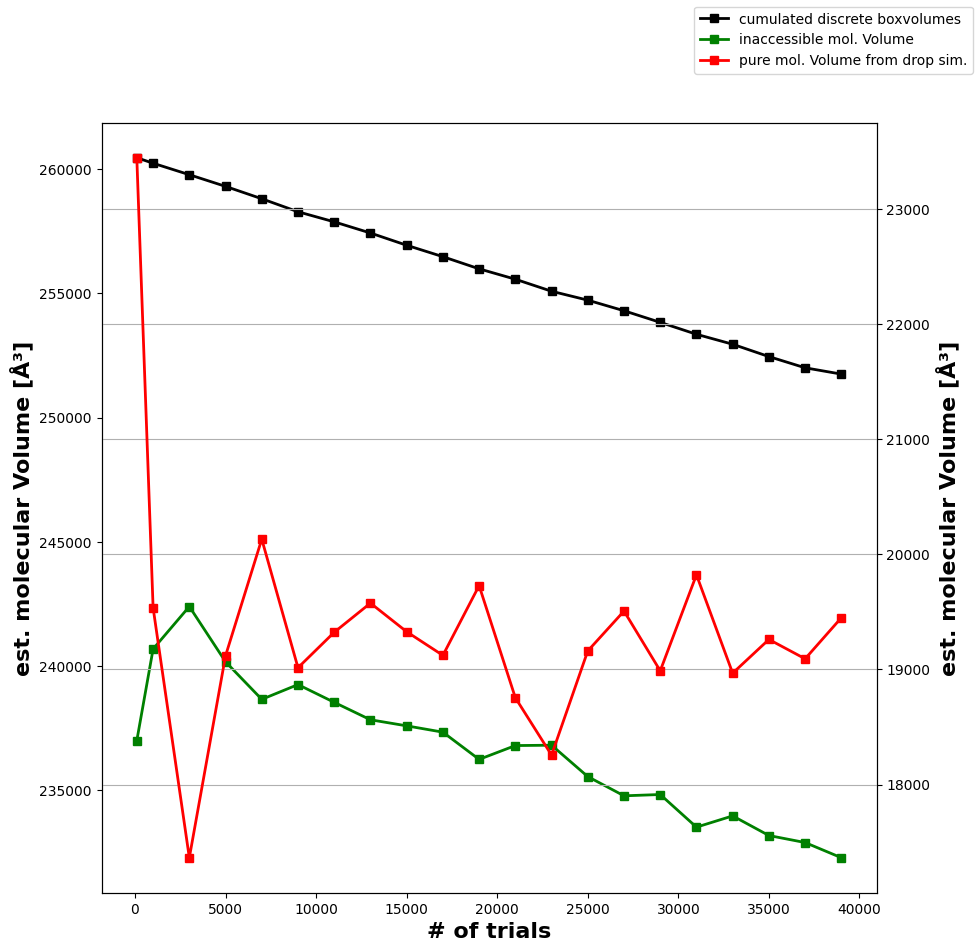

In [28]:
# test the influence of the number of trials

V_walk_vec = []
V_inacc_vec = []

for i, trial in enumerate(nt):

    dna_positions, walk_positions, dim = VoCalMol.init_positions(mode="walk", X=x, Y=y, Z=z, n_trials=trial,
                                                                 addboxlength=elongation, n_walker=n_walker)
    walk_positions, walk_acceptance = VoCalMol.walk_simulation(static_mol_pos=dna_positions,
                                                               dyn_mol_pos=walk_positions,
                                                               boxdim=dim,
                                                               r_over=overlap,
                                                               stepsize=steplength,
                                                               dyn_particle_radius=dpr)
    V_mol_walk, V_mol_inaccessible = VoCalMol.calc_inaccessible_molecule_volume(dyn_walk_pos=walk_positions,
                                                                                boxdim=dim,
                                                                                V_mol_drop=V_drop_vec[i],
                                                                                n_boxes=100)
    
    V_walk_vec.append(V_mol_walk)
    V_inacc_vec.append(V_mol_inaccessible)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel("# of trials",fontsize=16, fontweight="bold")
ax1.set_ylabel("est. molecular Volume [Å³]",fontsize=16, fontweight="bold")
ax1.plot(nt, V_walk_vec, linewidth = 2, marker="s", label="cumulated discrete boxvolumes", color="black")
ax1.plot(nt, V_inacc_vec, linewidth = 2, marker="s", label="inaccessible mol. Volume", color="green")

ax2 = ax1.twinx()
ax2.set_ylabel("est. molecular Volume [Å³]",fontsize=16, fontweight="bold")
ax2.plot(nt, V_drop_vec, linewidth = 2, marker="s", label="pure mol. Volume from drop sim.", color="red")
ax2.grid(True)
fig.legend(loc="upper right")


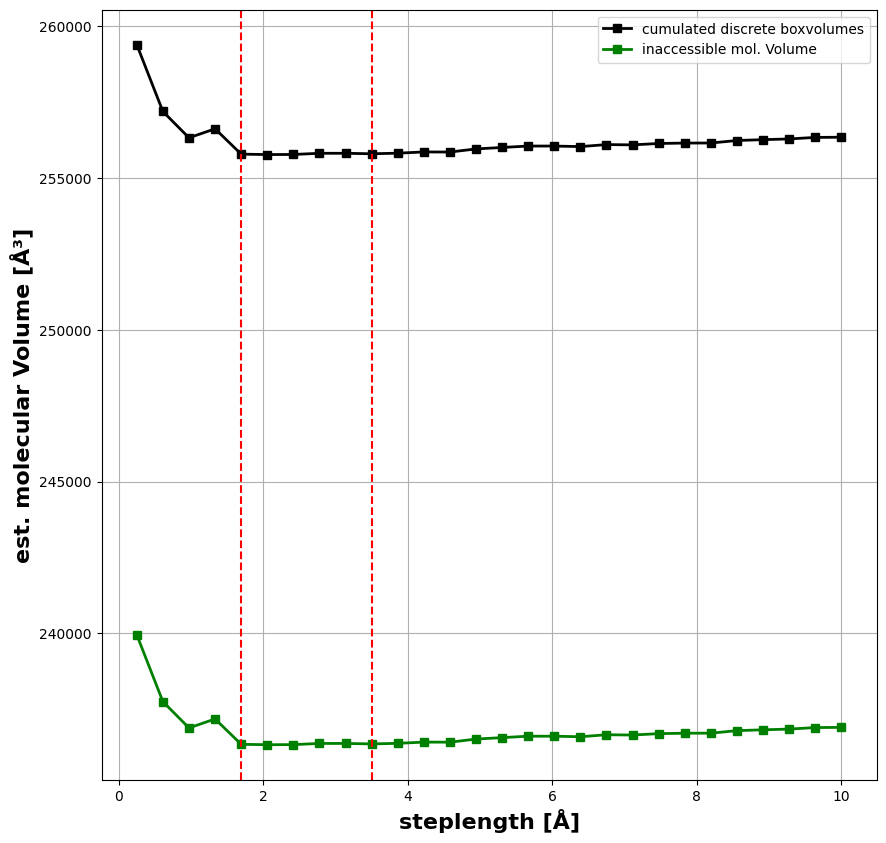

In [35]:
# test the influence of the stepsize of the walkers

V_walk_vec = []
V_inacc_vec = []
steps = np.linspace(.25,10,28)

for i, step in enumerate(steps):

    dna_positions, walk_positions, dim = VoCalMol.init_positions(mode="walk", X=x, Y=y, Z=z, n_trials=20000,
                                                                 addboxlength=elongation, n_walker=n_walker)
    walk_positions, walk_acceptance = VoCalMol.walk_simulation(static_mol_pos=dna_positions,
                                                               dyn_mol_pos=walk_positions,
                                                               boxdim=dim,
                                                               r_over=overlap,
                                                               stepsize=step,
                                                               dyn_particle_radius=dpr)
    V_mol_walk, V_mol_inaccessible = VoCalMol.calc_inaccessible_molecule_volume(dyn_walk_pos=walk_positions,
                                                                                boxdim=dim,
                                                                                V_mol_drop=V_drop_vec[-1],
                                                                                n_boxes=100)
    
    V_walk_vec.append(V_mol_walk)
    V_inacc_vec.append(V_mol_inaccessible)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel("steplength [Å]",fontsize=16, fontweight="bold")
ax1.set_ylabel("est. molecular Volume [Å³]",fontsize=16, fontweight="bold")
ax1.plot(steps, V_walk_vec, linewidth = 2, marker="s", label="cumulated discrete boxvolumes", color="black")
ax1.plot(steps, V_inacc_vec, linewidth = 2, marker="s", label="inaccessible mol. Volume", color="green")
ax1.axvline(x=steps[4], color='r', linestyle='--')
ax1.axvline(x=steps[9], color='r', linestyle='--')
ax1.grid(True)
ax1.legend(loc="upper right")

[[-100.0, 63.0], [-30.0, 17.0], [-17.0, 17.0]]


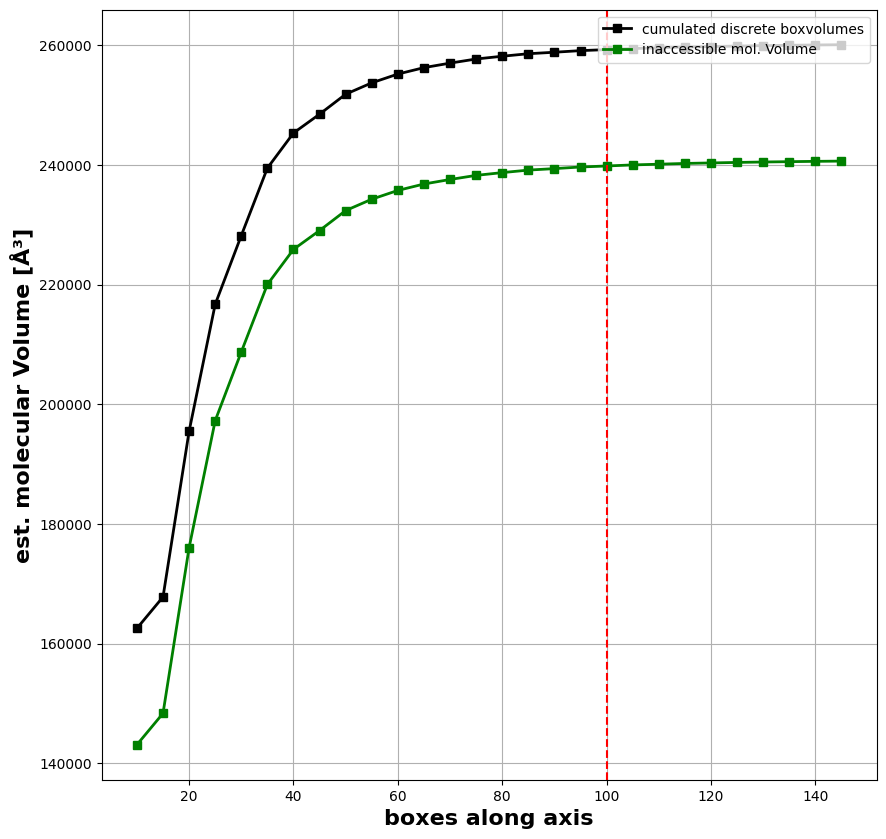

In [41]:
# test the influence of the discretization of the simuation box
print(dim)

#"""
V_walk_vec = []
V_inacc_vec = []
nb = np.arange(10,150,5)

for i, boxes in enumerate(nb):

    dna_positions, walk_positions, dim = VoCalMol.init_positions(mode="walk", X=x, Y=y, Z=z, n_trials=35000,
                                                                 addboxlength=elongation, n_walker=n_walker)
    walk_positions, walk_acceptance = VoCalMol.walk_simulation(static_mol_pos=dna_positions,
                                                               dyn_mol_pos=walk_positions,
                                                               boxdim=dim,
                                                               r_over=overlap,
                                                               stepsize=steplength,
                                                               dyn_particle_radius=dpr)
    V_mol_walk, V_mol_inaccessible = VoCalMol.calc_inaccessible_molecule_volume(dyn_walk_pos=walk_positions,
                                                                                boxdim=dim,
                                                                                V_mol_drop=V_drop_vec[-1],
                                                                                n_boxes=boxes)
    
    V_walk_vec.append(V_mol_walk)
    V_inacc_vec.append(V_mol_inaccessible)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel("boxes along axis",fontsize=16, fontweight="bold")
ax1.set_ylabel("est. molecular Volume [Å³]",fontsize=16, fontweight="bold")
ax1.plot(nb, V_walk_vec, linewidth = 2, marker="s", label="cumulated discrete boxvolumes", color="black")
ax1.plot(nb, V_inacc_vec, linewidth = 2, marker="s", label="inaccessible mol. Volume", color="green")
ax1.axvline(x=100, color='r', linestyle='--')
ax1.grid(True)
ax1.legend(loc="upper right")
#"""